In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import squarify
# NLP
import nltk
import swifter
from nltk.corpus import stopwords
from collections import Counter

import datetime as dt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
import os

PROJECT_ROOT_DIR ="."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id+"."+fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

In [2]:
data0910 = pd.read_csv("dataset/data0910.csv")
data1011 = pd.read_csv("dataset/data1011.csv")

In [3]:
data = pd.concat([data0910, data1011], axis=0)

In [4]:
data = data.drop_duplicates()

In [5]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      4275
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235151
Country             0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033036 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1033036 non-null  object 
 1   StockCode    1033036 non-null  object 
 2   Description  1028761 non-null  object 
 3   Quantity     1033036 non-null  int64  
 4   InvoiceDate  1033036 non-null  object 
 5   Price        1033036 non-null  float64
 6   Customer ID  797885 non-null   float64
 7   Country      1033036 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 70.9+ MB


In [7]:
data = data.dropna()

In [8]:
data['date'] = data['InvoiceDate'].apply(lambda x : x.split()[0])
data['time'] = data['InvoiceDate'].apply(lambda x : x.split()[1])

data['hour'] = data['time'].apply(lambda x : x.split(':')[0])

data['date'] = data['date'].apply(lambda x : datetime.strptime(x, '%m/%d/%Y'))
data['year'] = data['date'].apply(lambda x : x.year)
data['month'] = data['date'].apply(lambda x : x.month)
data['day'] = data['date'].apply(lambda x : x.day)
data ['quarter'] = data['date'].apply(lambda x : x.quarter)
data['weekday'] = data['date'].apply(lambda x : x.day_name())

data['total_price'] = data['Quantity'] * data['Price']

In [9]:
data.describe()

,Quantity,Price,Customer ID,year,month,day,quarter,total_price
count,797885.000000,797885.000000,797885.000000,797885.000000,797885.000000,797885.000000,797885.000000,797885.000000
mean,12.602980,3.702732,15313.062777,2010.431108,7.411434,15.387388,2.795019,20.416465
std,191.670371,71.392549,1696.466663,0.568904,3.424495,8.658264,1.132430,313.518824
min,-80995.000000,0.000000,12346.000000,2009.000000,1.000000,1.000000,1.000000,-168469.600000
25%,2.000000,1.250000,13964.000000,2010.000000,5.000000,8.000000,2.000000,4.350000
50%,5.000000,1.950000,15228.000000,2010.000000,8.000000,15.000000,3.000000,11.700000
75%,12.000000,3.750000,16788.000000,2011.000000,10.000000,23.000000,4.000000,19.500000
max,80995.000000,38970.000000,18287.000000,2011.000000,12.000000,31.000000,4.000000,168469.600000


### Quantity -1 인 이유 
    - 취소된 상품
    - 취소되면 'InvoiceNo'에 C가 붙게됨

In [10]:
tmp = data[data['Quantity'] < 0]

In [11]:
tmp[tmp['Invoice'].str.find("C") == 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,time,hour,year,month,day,quarter,weekday,total_price
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,12/1/2009 10:33,2.95,16321.0,Australia,2009-12-01,10:33,10,2009,12,1,4,Tuesday,-35.40
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,12/1/2009 10:33,1.65,16321.0,Australia,2009-12-01,10:33,10,2009,12,1,4,Tuesday,-9.90
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,12/1/2009 10:33,4.25,16321.0,Australia,2009-12-01,10:33,10,2009,12,1,4,Tuesday,-17.00
181,C489449,21896,POTTING SHED TWINE,-6,12/1/2009 10:33,2.10,16321.0,Australia,2009-12-01,10:33,10,2009,12,1,4,Tuesday,-12.60
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,12/1/2009 10:33,2.95,16321.0,Australia,2009-12-01,10:33,10,2009,12,1,4,Tuesday,-35.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom,2011-12-09,9:57,9,2011,12,9,4,Friday,-9.13
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom,2011-12-09,10:28,10,2011,12,9,4,Friday,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom,2011-12-09,11:57,11,2011,12,9,4,Friday,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom,2011-12-09,11:58,11,2011,12,9,4,Friday,-1.25


In [12]:
data = data[~data["Invoice"].str.contains("C")]
data = data[data["Quantity"] > 0]

### StockCode의 규칙
 - 문자로 이루어진 stockcode는 description도 통일되어 있음

In [13]:
# 문자로만
stockcode = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]
stockcode['StockCode'].value_counts()

POST            1803
M                688
C2               248
ADJUST            32
BANK CHARGES      31
PADS              18
DOT               16
TEST001           11
D                  5
ADJUST2            3
SP1002             2
TEST002            1
Name: StockCode, dtype: int64

In [14]:
# stockcode 문자 dropna : 상품에 대한 것이 아니기 때문
data = data[~data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]

In [15]:
# pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20, 20))
# plt.show();

### Country
 - 'Unspecified'가 있음

In [16]:
data[data['Country'] == 'Unspecified']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,time,hour,year,month,day,quarter,weekday,total_price
61394,494860,84832,ZINC WILLIE WINKIE CANDLE STICK,5,1/19/2010 11:01,0.85,12470.0,Unspecified,2010-01-19,11:01,11,2010,1,19,1,Tuesday,4.25
61395,494860,84836,ZINC METAL HEART DECORATION,5,1/19/2010 11:01,1.25,12470.0,Unspecified,2010-01-19,11:01,11,2010,1,19,1,Tuesday,6.25
61396,494860,85014D,PINK/BROWN DOTS RUFFLED UMBRELLA,1,1/19/2010 11:01,5.95,12470.0,Unspecified,2010-01-19,11:01,11,2010,1,19,1,Tuesday,5.95
61397,494860,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,1,1/19/2010 11:01,5.95,12470.0,Unspecified,2010-01-19,11:01,11,2010,1,19,1,Tuesday,5.95
61398,494860,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,2,1/19/2010 11:01,5.95,12470.0,Unspecified,2010-01-19,11:01,11,2010,1,19,1,Tuesday,11.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308810,564051,23007,SPACEBOY BABY GIFT SET,1,8/22/2011 13:32,16.95,14265.0,Unspecified,2011-08-22,13:32,13,2011,8,22,3,Monday,16.95
308811,564051,21833,CAMOUFLAGE LED TORCH,12,8/22/2011 13:32,1.69,14265.0,Unspecified,2011-08-22,13:32,13,2011,8,22,3,Monday,20.28
308812,564051,23081,GREEN METAL BOX ARMY SUPPLIES,2,8/22/2011 13:32,8.25,14265.0,Unspecified,2011-08-22,13:32,13,2011,8,22,3,Monday,16.50
308813,564051,23046,PAPER LANTERN 9 POINT DELUXE STAR,2,8/22/2011 13:32,6.65,14265.0,Unspecified,2011-08-22,13:32,13,2011,8,22,3,Monday,13.30


In [17]:
data[data['Country'] != 'Unspecified']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,time,hour,year,month,day,quarter,weekday,total_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom,2009-12-01,7:45,7,2009,12,1,4,Tuesday,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom,2009-12-01,7:45,7,2009,12,1,4,Tuesday,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom,2009-12-01,7:45,7,2009,12,1,4,Tuesday,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom,2009-12-01,7:45,7,2009,12,1,4,Tuesday,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom,2009-12-01,7:45,7,2009,12,1,4,Tuesday,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,2011-12-09,12:50,12,2011,12,9,4,Friday,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,2011-12-09,12:50,12,2011,12,9,4,Friday,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,2011-12-09,12:50,12,2011,12,9,4,Friday,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,2011-12-09,12:50,12,2011,12,9,4,Friday,16.60


### Country

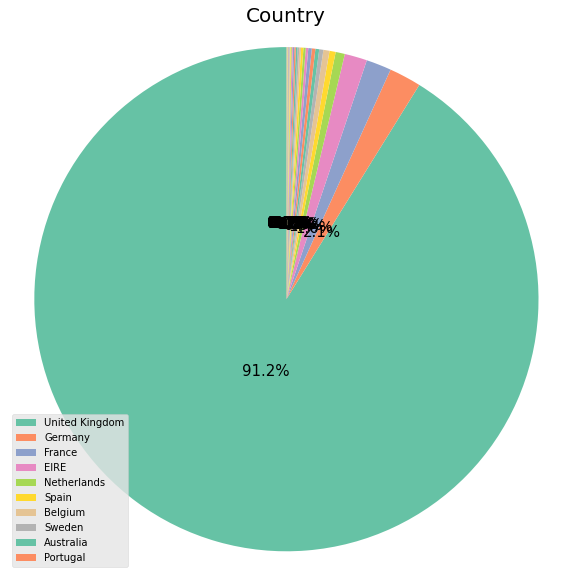

In [18]:
country = data[['Invoice', 'Country', 'Customer ID']].groupby(['Customer ID', 'Country', 'Invoice']).count().reset_index()

plt.figure(figsize=(10, 10))
plt.pie(country['Country'].value_counts(),
         autopct='%0.1f%%',
         textprops={'fontsize': 15},
         pctdistance=0.3,
         startangle=90,
         colors=sns.color_palette("Set2"))
plt.title("Country", fontsize=20)
plt.axis('equal') 
plt.legend(country['Country'].value_counts()[:10].index, loc='lower left', fontsize=10)
# save_fig("country most transaction")
# plt.show();

In [19]:
pd.DataFrame(country['Country'].value_counts()[:10] / country['Country'].count() * 100)

,Country
United Kingdom,91.163210
Germany,2.057546
France,1.612154
EIRE,1.442741
Netherlands,0.592945
Spain,0.393475
Belgium,0.390742
Sweden,0.267782
Australia,0.243189
Portugal,0.226795


[Text(0, 0, 'Australia'),
 Text(1, 0, 'Austria'),
 Text(2, 0, 'Bahrain'),
 Text(3, 0, 'Belgium'),
 Text(4, 0, 'Brazil'),
 Text(5, 0, 'Canada'),
 Text(6, 0, 'Channel Islands'),
 Text(7, 0, 'Cyprus'),
 Text(8, 0, 'Czech Republic'),
 Text(9, 0, 'Denmark'),
 Text(10, 0, 'EIRE'),
 Text(11, 0, 'European Community'),
 Text(12, 0, 'Finland'),
 Text(13, 0, 'France'),
 Text(14, 0, 'Germany'),
 Text(15, 0, 'Greece'),
 Text(16, 0, 'Iceland'),
 Text(17, 0, 'Israel'),
 Text(18, 0, 'Italy'),
 Text(19, 0, 'Japan'),
 Text(20, 0, 'Korea'),
 Text(21, 0, 'Lebanon'),
 Text(22, 0, 'Lithuania'),
 Text(23, 0, 'Malta'),
 Text(24, 0, 'Netherlands'),
 Text(25, 0, 'Nigeria'),
 Text(26, 0, 'Norway'),
 Text(27, 0, 'Poland'),
 Text(28, 0, 'Portugal'),
 Text(29, 0, 'RSA'),
 Text(30, 0, 'Saudi Arabia'),
 Text(31, 0, 'Singapore'),
 Text(32, 0, 'Spain'),
 Text(33, 0, 'Sweden'),
 Text(34, 0, 'Switzerland'),
 Text(35, 0, 'Thailand'),
 Text(36, 0, 'USA'),
 Text(37, 0, 'United Arab Emirates'),
 Text(38, 0, 'United Kingdom')

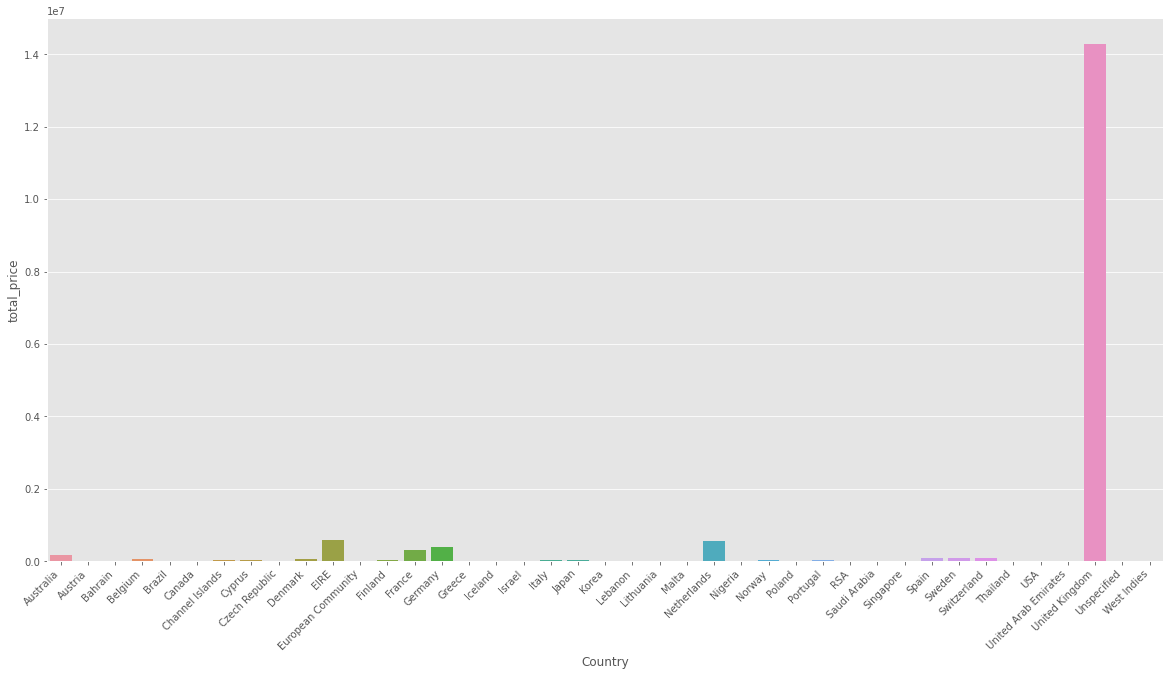

In [20]:
country_total = data[['total_price', 'Country', 'Customer ID']].groupby(['Country']).sum().reset_index()
plt.figure(figsize=(20,10))
plot = sns.barplot(x=country_total['Country'], y=country_total['total_price'])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
# save_fig("country most revenue")
# plt.show();

[Text(0, 0, 'Australia'),
 Text(1, 0, 'Austria'),
 Text(2, 0, 'Bahrain'),
 Text(3, 0, 'Belgium'),
 Text(4, 0, 'Brazil'),
 Text(5, 0, 'Canada'),
 Text(6, 0, 'Channel Islands'),
 Text(7, 0, 'Cyprus'),
 Text(8, 0, 'Czech Republic'),
 Text(9, 0, 'Denmark'),
 Text(10, 0, 'EIRE'),
 Text(11, 0, 'European Community'),
 Text(12, 0, 'Finland'),
 Text(13, 0, 'France'),
 Text(14, 0, 'Germany'),
 Text(15, 0, 'Greece'),
 Text(16, 0, 'Iceland'),
 Text(17, 0, 'Israel'),
 Text(18, 0, 'Italy'),
 Text(19, 0, 'Japan'),
 Text(20, 0, 'Korea'),
 Text(21, 0, 'Lebanon'),
 Text(22, 0, 'Lithuania'),
 Text(23, 0, 'Malta'),
 Text(24, 0, 'Netherlands'),
 Text(25, 0, 'Nigeria'),
 Text(26, 0, 'Norway'),
 Text(27, 0, 'Poland'),
 Text(28, 0, 'Portugal'),
 Text(29, 0, 'RSA'),
 Text(30, 0, 'Saudi Arabia'),
 Text(31, 0, 'Singapore'),
 Text(32, 0, 'Spain'),
 Text(33, 0, 'Sweden'),
 Text(34, 0, 'Switzerland'),
 Text(35, 0, 'Thailand'),
 Text(36, 0, 'USA'),
 Text(37, 0, 'United Arab Emirates'),
 Text(38, 0, 'United Kingdom')

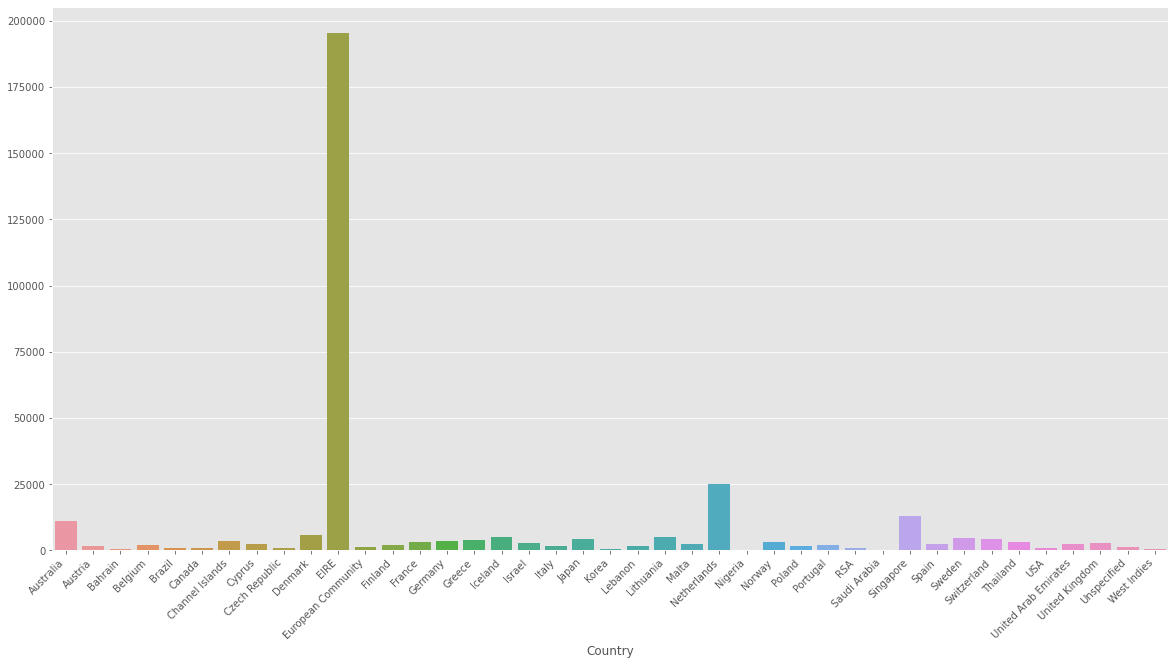

In [21]:
country_average = data.groupby(['Country']).sum()['total_price'] / data.groupby(['Country']).nunique()['Customer ID']
plt.figure(figsize=(20,10))
plot = sns.barplot(x=country_average.index, y=country_average)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
# save_fig("country most average revenue per paying user")
# plt.show();

### date

In [23]:
data = data.astype({'hour':"int64"})

그림 저장: date analysis


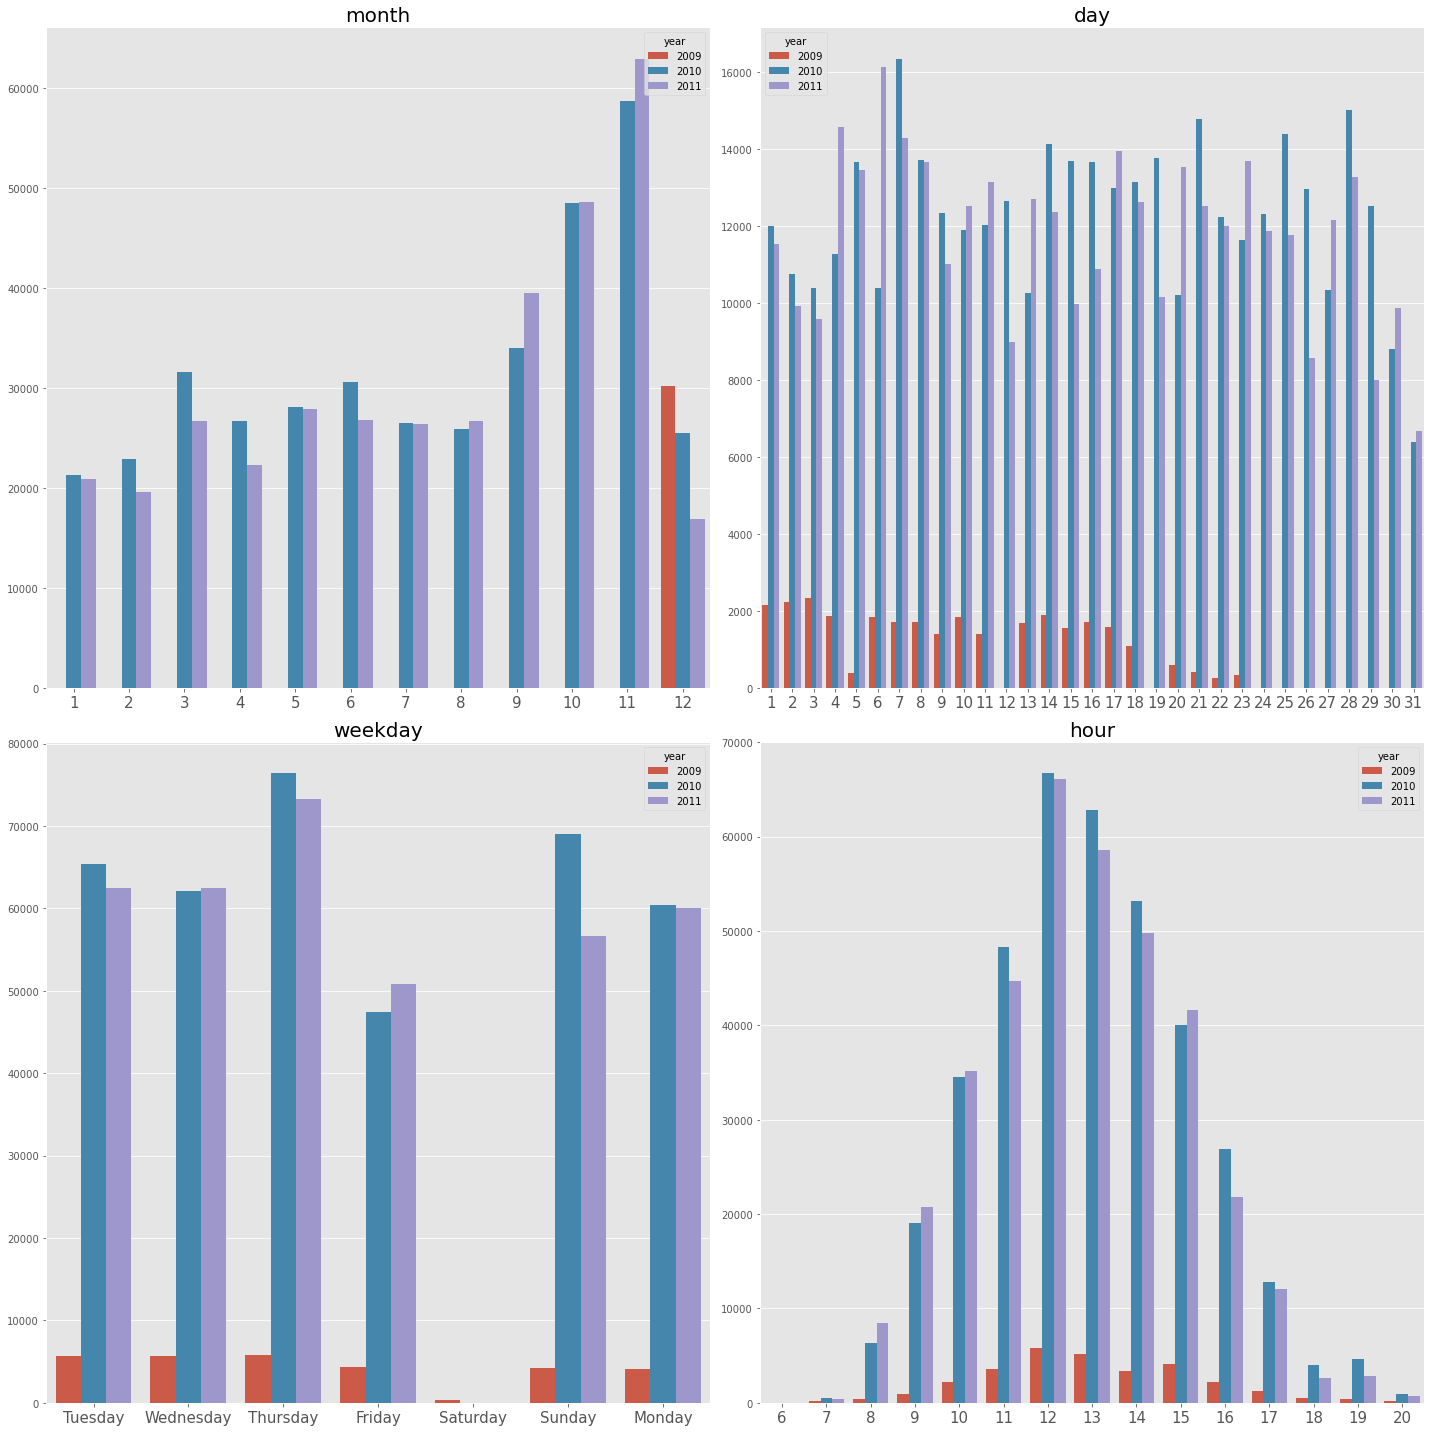

In [79]:
column_list = ['month', 'day', 'weekday', 'hour']

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
i = 0

for idx, var in enumerate(column_list):
    i = 0
    j = 0
    i = i if idx < 2 else i + 1
    j = j if idx % 2 == 0 else j + 1
    
    sns.countplot(x=data[var], hue=data['year'], ax=ax[i][j]).set_title(f'{var}'.format(), fontsize=20)
    ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=0, size=15)
    ax[i][j].set_xlabel("")
    ax[i][j].set_ylabel("")

save_fig("date analysis")
plt.show();

### revenue

In [80]:
# # 2011년 12월 데이터 삭제 : 전체 달의 데이터가 다 있는게 아니라 9일까지만 있음
# data = data[~((data['year'] == 2011) & (data['month'] == 12))] 

- ARPPU(Average Revenue Per Paying User)
    - ARPPU = total revenue / user

In [81]:
total_revenue = data['total_price'].sum()
total_revenue

17068567.970000006

In [82]:
user = data['Customer ID'].nunique()
user

5853

In [83]:
ARPPU = total_revenue / user
ARPPU

2916.208434990604

- Year ARPPU(Average Revenue Per Paying User)

In [84]:
YARPPU = data.groupby(['year']).sum()['total_price'] / data.groupby(['year']).nunique()['Customer ID']
YARPPU_df = YARPPU.to_frame().reset_index().rename(columns={0 : 'YARPPU'})
YARPPU_df

,year,YARPPU
0,2009,712.845499
1,2010,1954.488423
2,2011,1938.796698


그림 저장: YARPPU


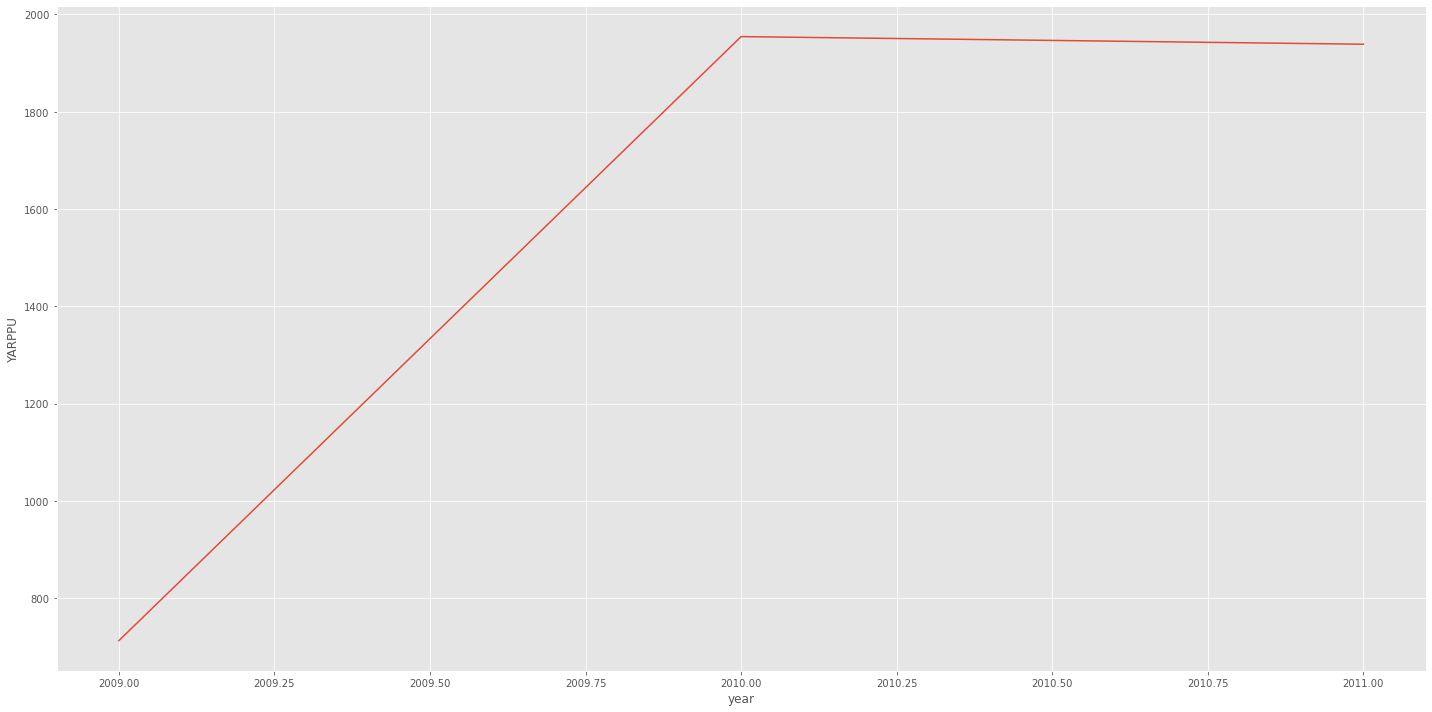

In [85]:
plt.figure(figsize=(20,10))
sns.lineplot(x=YARPPU_df['year'], y=YARPPU_df['YARPPU'])
save_fig("YARPPU")
plt.show();

- Quater ARPPU(Average Revenue Per Paying User)

In [86]:
QARPPU = data.groupby(['year', 'quarter']).sum()['total_price'] / data.groupby(['year','quarter']).nunique()['Customer ID']
QARPPU_df = QARPPU.to_frame().reset_index().rename(columns={0 : 'QARPPU'})
QARPPU_df

,year,quarter,QARPPU
0,2009,4,712.845499
1,2010,1,952.116781
2,2010,2,885.623020
3,2010,3,966.159893
4,2010,4,1025.416398
5,2011,1,895.220039
6,2011,2,888.806987
7,2011,3,1005.044455
8,2011,4,1035.581500


그림 저장: QARPPU


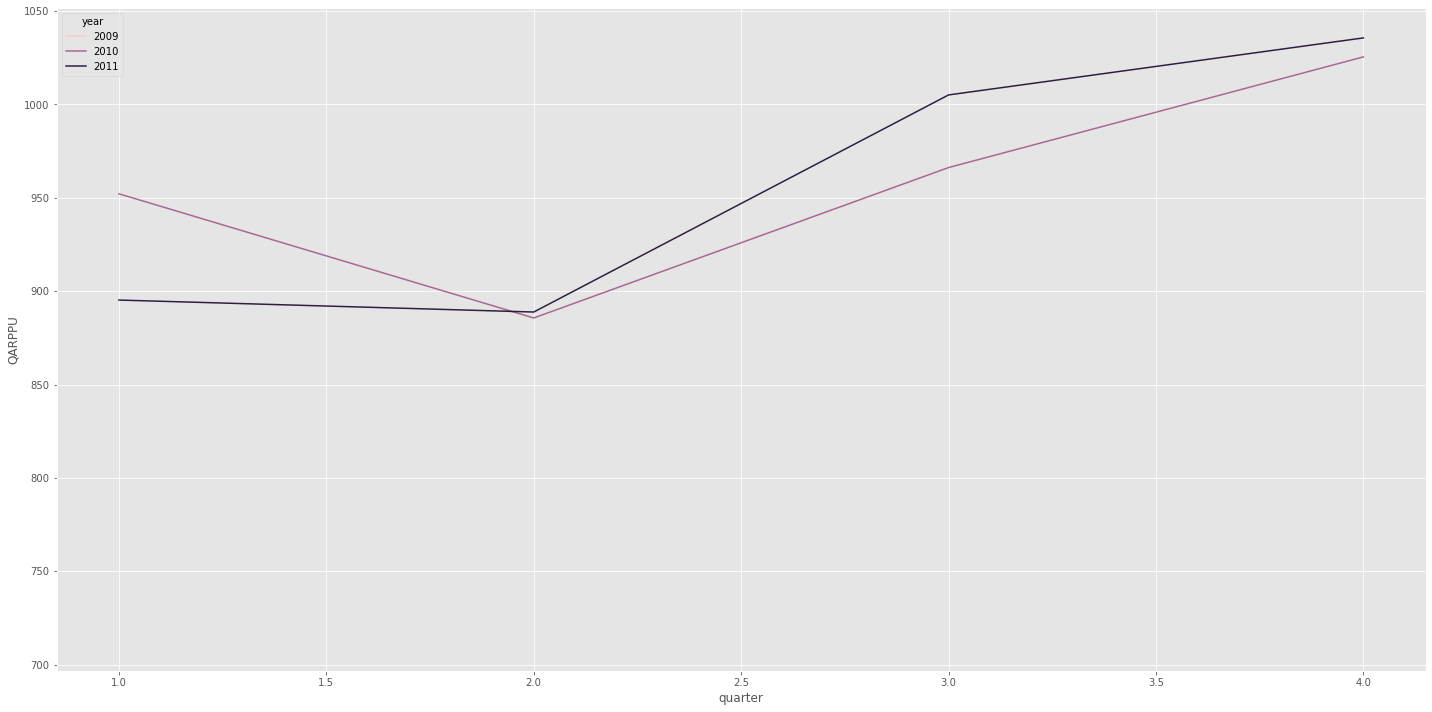

In [87]:
plt.figure(figsize=(20,10))
sns.lineplot(x=QARPPU_df['quarter'], y=QARPPU_df['QARPPU'], hue=QARPPU_df['year'])
save_fig("QARPPU")
plt.show();

- Monthly ARPPU(Average Revenue Per Paying User)

In [88]:
data = data.astype({'year':"int",
                         'month':"int",
                         'day':'int'})

In [89]:
MARPPU = data.groupby(['year','month']).sum()['total_price'] / data.groupby(['year','month']).nunique()['Customer ID']
MARPPU_df = MARPPU.to_frame().reset_index().rename(columns={0 : 'MARPPU'})
MARPPU_df

,year,month,MARPPU
0,2009,12,712.845499
1,2010,1,761.359458
2,2010,2,645.833424
3,2010,3,633.657155
4,2010,4,623.138903
5,2010,5,614.232259
6,2010,6,608.132882
7,2010,7,629.315974
8,2010,8,653.363923
9,2010,9,709.106347


그림 저장: MARPPU


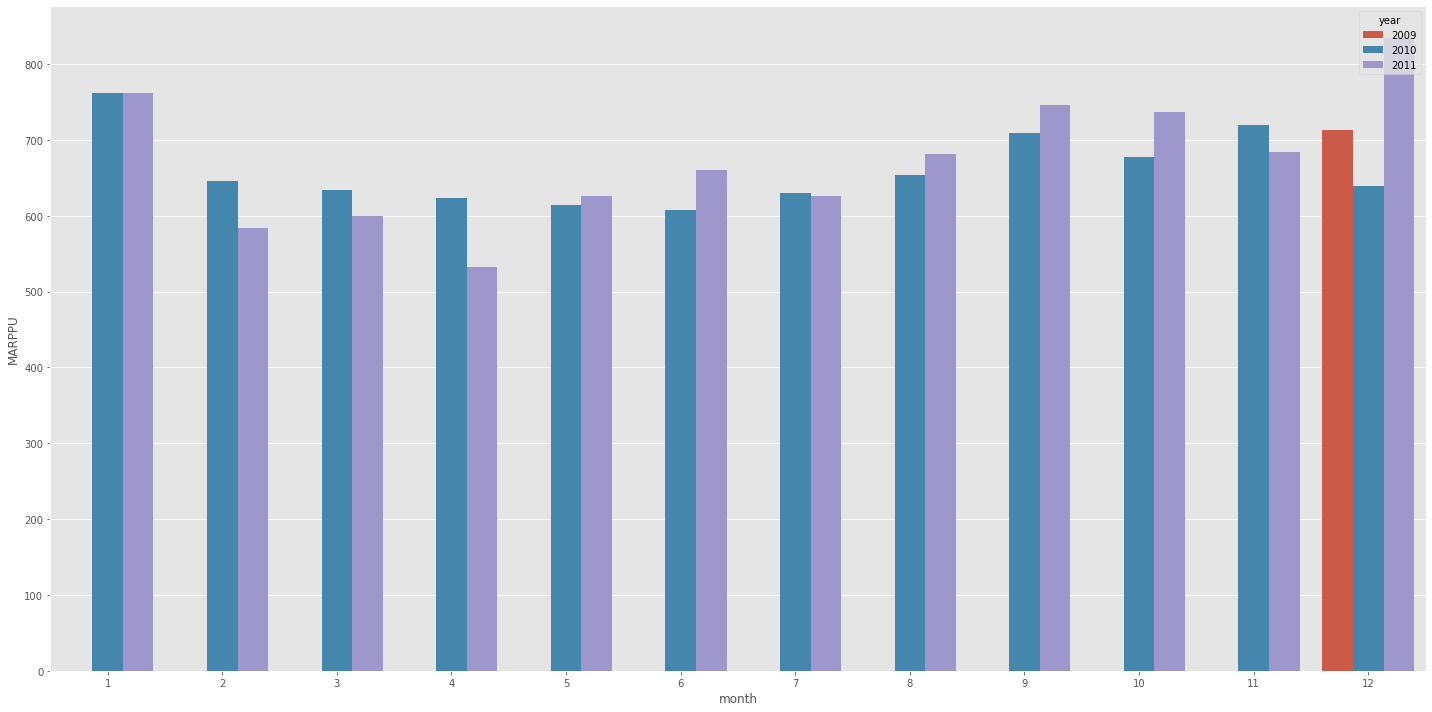

In [90]:
plt.figure(figsize=(20,10))
sns.barplot(x=MARPPU_df['month'], y=MARPPU_df['MARPPU'], hue=MARPPU_df['year'])
save_fig("MARPPU")
plt.show();

- Daily ARPPU(Average Revenue Per Paying User)

In [91]:
DARPPU = data.groupby(['year','month', 'day']).sum()['total_price'] / data.groupby(['year','month', 'day']).nunique()['Customer ID']
DARPPU_df = DARPPU.to_frame().reset_index().rename(columns={0 : 'DARPPU'})

그림 저장: DARPPU


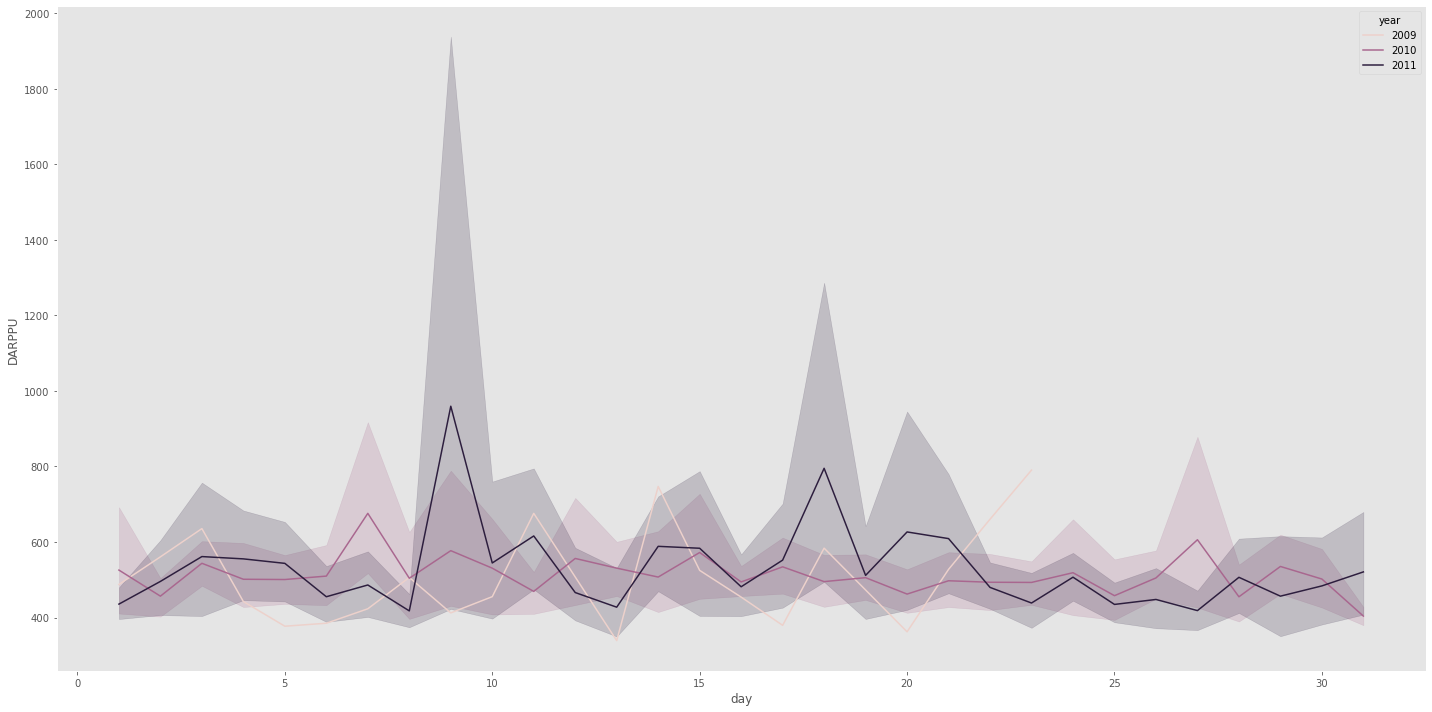

In [92]:
plt.figure(figsize=(20,10))
plt.grid()
sns.lineplot(x=DARPPU_df['day'], y=DARPPU_df['DARPPU'], hue=DARPPU_df['year'])
save_fig("DARPPU")
plt.show();

그림 저장: DARPPU by Month


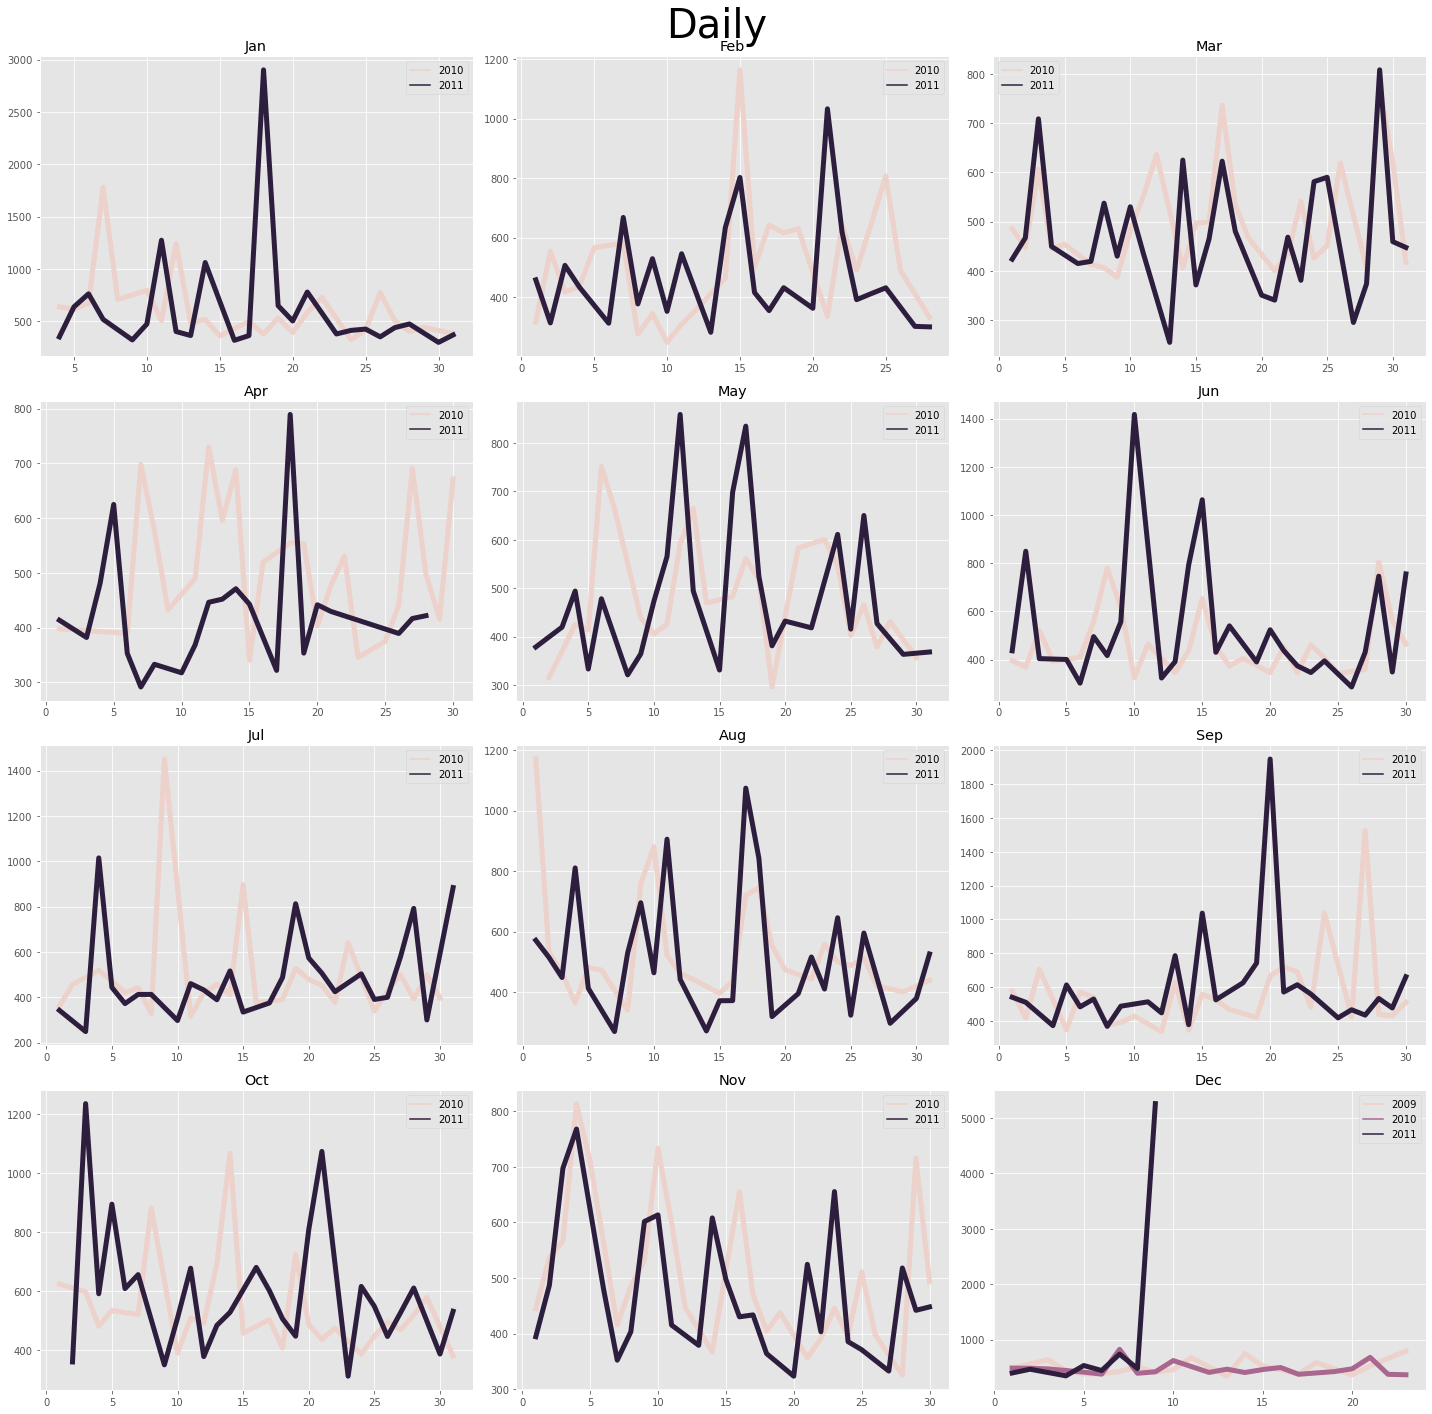

In [93]:
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle('Daily', fontsize=40)

column_idx = 1
var_list = ["","Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for i in range(4):
    for j in range(3):
        df = DARPPU_df[DARPPU_df['month'] == column_idx]
        sns.lineplot(x=df['day'], y=df['DARPPU'], hue=df['year'], linewidth=5, ax = ax[i][j])
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('')
        ax[i][j].set_title(var_list[column_idx])
        ax[i][j].legend()
        column_idx += 1
save_fig("DARPPU by Month")
plt.show();

- ASP(Average Selling Price)

In [94]:
ASP = data.groupby(['year','month']).sum()['total_price'] / data.groupby(['year','month']).sum()['Quantity']
ASP_df = ASP.to_frame().reset_index().rename(columns={0 : 'ASP'})
ASP_df

,year,month,ASP
0,2009,12,1.701016
1,2010,1,1.442776
2,2010,2,1.339774
3,2010,3,1.328517
4,2010,4,1.671568
5,2010,5,1.541146
6,2010,6,1.614833
7,2010,7,1.792392
8,2010,8,1.314886
9,2010,9,1.419730


그림 저장: ASP


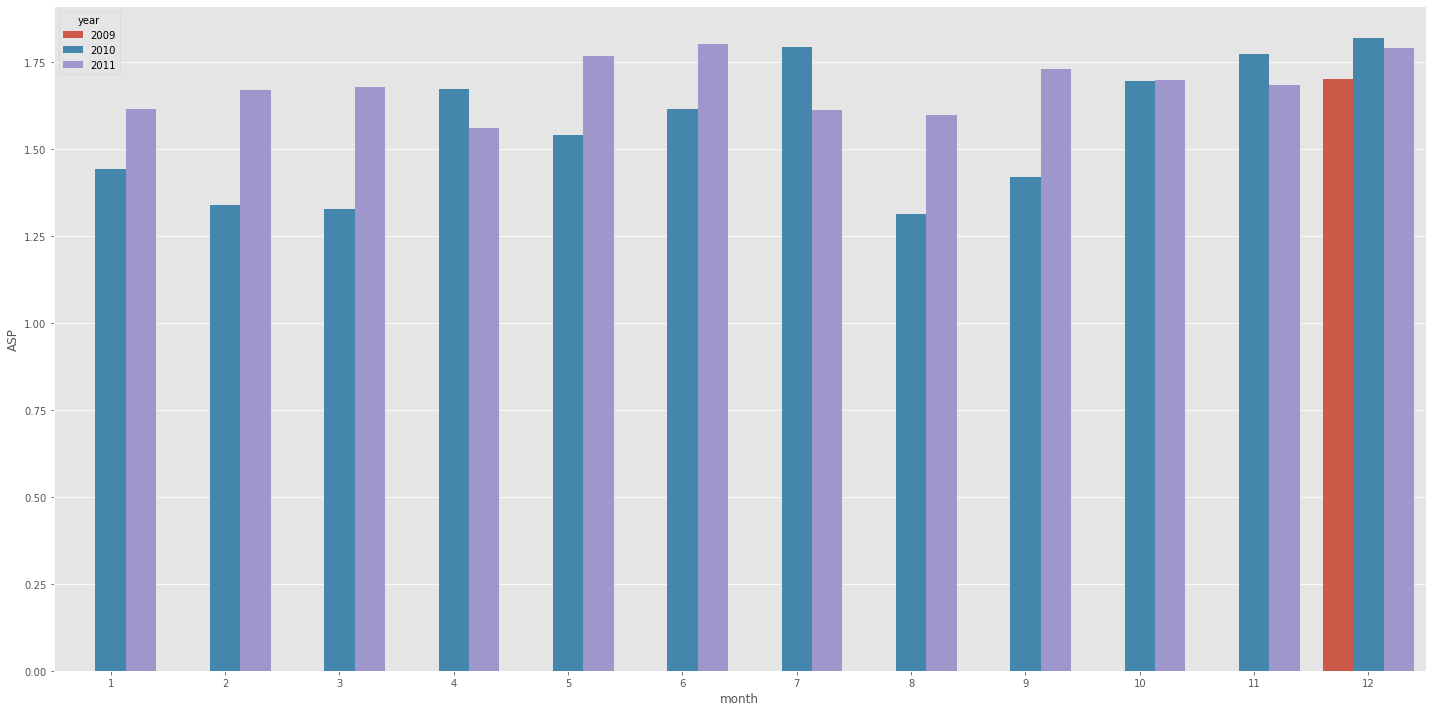

In [95]:
plt.figure(figsize=(20,10))
sns.barplot(x=ASP_df['month'], y=ASP_df['ASP'], hue=ASP_df['year'])
save_fig("ASP")
plt.show();

- RFM analysis
    - Recency (affects retention, a measure of engagement)
    - Frequency (affects a customer’s lifetime value)
    - Monetary (affects a customer’s lifetime value)
    - Segment :
        - Champions: Bought recently, buy often and spend the most
        - Loyal customers: Buy on a regular basis. Responsive to promotions.
        - Potential loyalist: Recent customers with average frequency.
        - New customers: Bought most recently, but not often.
        - Promising: Recent shoppers, but haven’t spent much.
        - Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.
        - About to sleep: Below average recency and frequency. Will lose them if not reactivated.
        - At risk: Some time since they’ve purchased. Need to bring them back!
        - Can’t loose them: Used to purchase frequently but haven’t returned for a long time.
        - Hibernating: Last purchase was long back and low number of orders. May be lost.

In [96]:
# 기준 날짜 : 2011년 12월 10일 -> 가장 마지막 거래가 이루어진 날짜가 2011년 12월 9일이기 때문
standard_date = dt.datetime(2011, 12, 10)
RFM = data.groupby('Customer ID').agg({'date' : lambda date : (standard_date - date.max()).days,
                                'Invoice' : lambda Invoice : Invoice.nunique(),
                                'total_price' : lambda total_price : total_price.sum()})

In [97]:
RFM = RFM.reset_index()
RFM = RFM.rename(columns = {'date' : 'recency',
                     'Invoice' : 'frequency',
                     'total_price' : 'monetary'})

In [98]:
RFM[RFM['monetary'] < 0]

,Customer ID,recency,frequency,monetary


In [99]:
# RFM Scores
RFM['R'] = pd.qcut(RFM['recency'], 5, labels=[5,4,3,2,1])
# 같은 개수로 나누고 싶은데 중복값이 있을 경우
RFM['F'] = pd.qcut(RFM['frequency'].rank(method="first"), 5, labels=[5,4,3,2,1])
RFM['M'] = pd.qcut(RFM['monetary'], 5, labels=[5,4,3,2,1])

In [102]:
# segment
# R,F 점수 이용
segment_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At risk',
    r'[1-2]5': 'Can\'t loose them',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
}
RFM['segment'] = RFM['R'].astype(str) + RFM['F'].astype(str)
RFM['segment'] = RFM['segment'].replace(segment_map, regex=True)

그림 저장: segment count


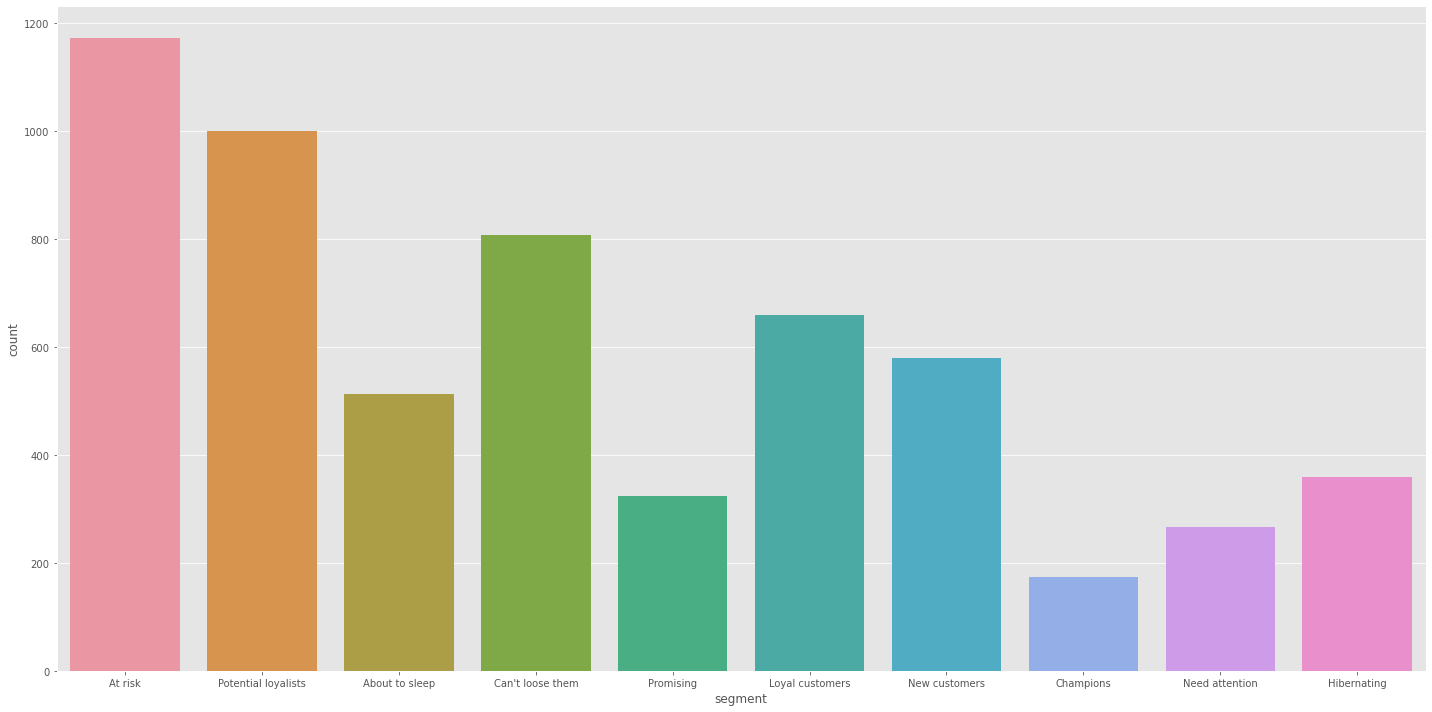

In [103]:
plt.figure(figsize=(20,10))
sns.countplot(RFM['segment'])
save_fig("segment count")
plt.show();

In [104]:
RFM['segment'].unique()

array(['At risk', 'Potential loyalists', 'About to sleep',
       "Can't loose them", 'Promising', 'Loyal customers',
       'New customers', 'Champions', 'Need attention', 'Hibernating'],
      dtype=object)

그림 저장: RFM Segments


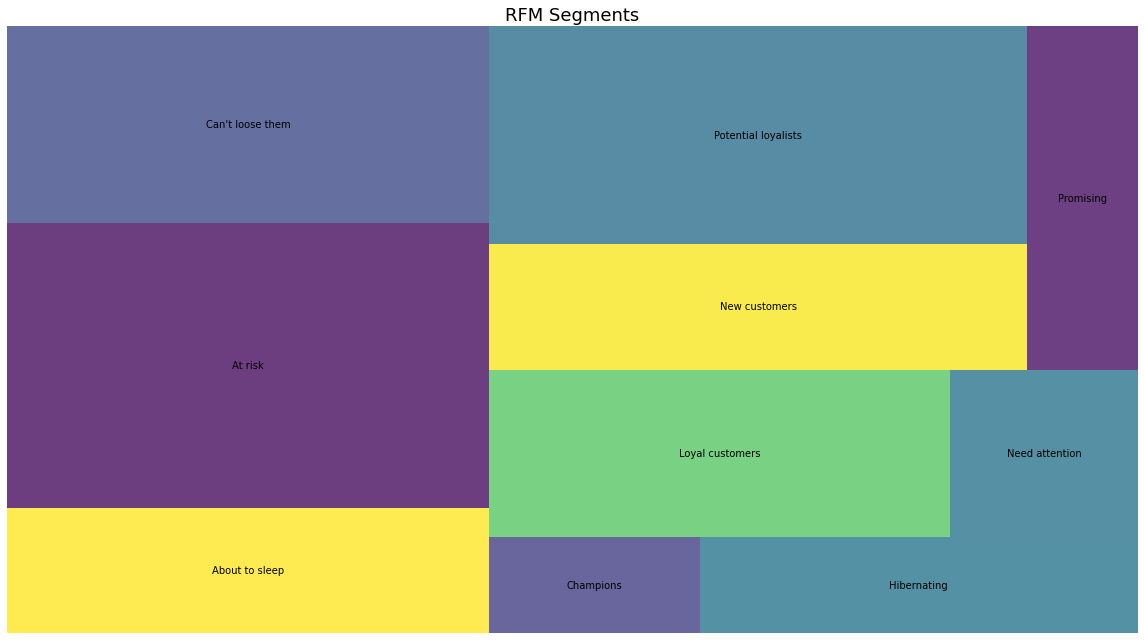

In [105]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
# color = 

squarify.plot(sizes=RFM.groupby('segment').count()['Customer ID'],
             label=RFM.groupby('segment').count()['Customer ID'].index,
             alpha=0.8)
plt.title("RFM Segments", fontsize=18)
plt.axis("off")
save_fig("RFM Segments")
plt.show();

In [106]:
RFM_data = pd.merge(data, RFM, how="left")
RFM_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,time,...,quarter,weekday,total_price,recency,frequency,monetary,R,F,M,segment
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom,2009-12-01,7:45,...,4,Tuesday,83.40,158,8,2433.28,3,2,2,About to sleep
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom,2009-12-01,7:45,...,4,Tuesday,81.00,158,8,2433.28,3,2,2,About to sleep
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom,2009-12-01,7:45,...,4,Tuesday,81.00,158,8,2433.28,3,2,2,About to sleep
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom,2009-12-01,7:45,...,4,Tuesday,100.80,158,8,2433.28,3,2,2,About to sleep
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom,2009-12-01,7:45,...,4,Tuesday,30.00,158,8,2433.28,3,2,2,About to sleep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776632,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,2011-12-09,12:50,...,4,Friday,10.20,1,4,790.81,5,3,3,Potential loyalists
776633,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,2011-12-09,12:50,...,4,Friday,12.60,1,4,790.81,5,3,3,Potential loyalists
776634,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,2011-12-09,12:50,...,4,Friday,16.60,1,4,790.81,5,3,3,Potential loyalists
776635,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,2011-12-09,12:50,...,4,Friday,16.60,1,4,790.81,5,3,3,Potential loyalists


그림 저장: recency


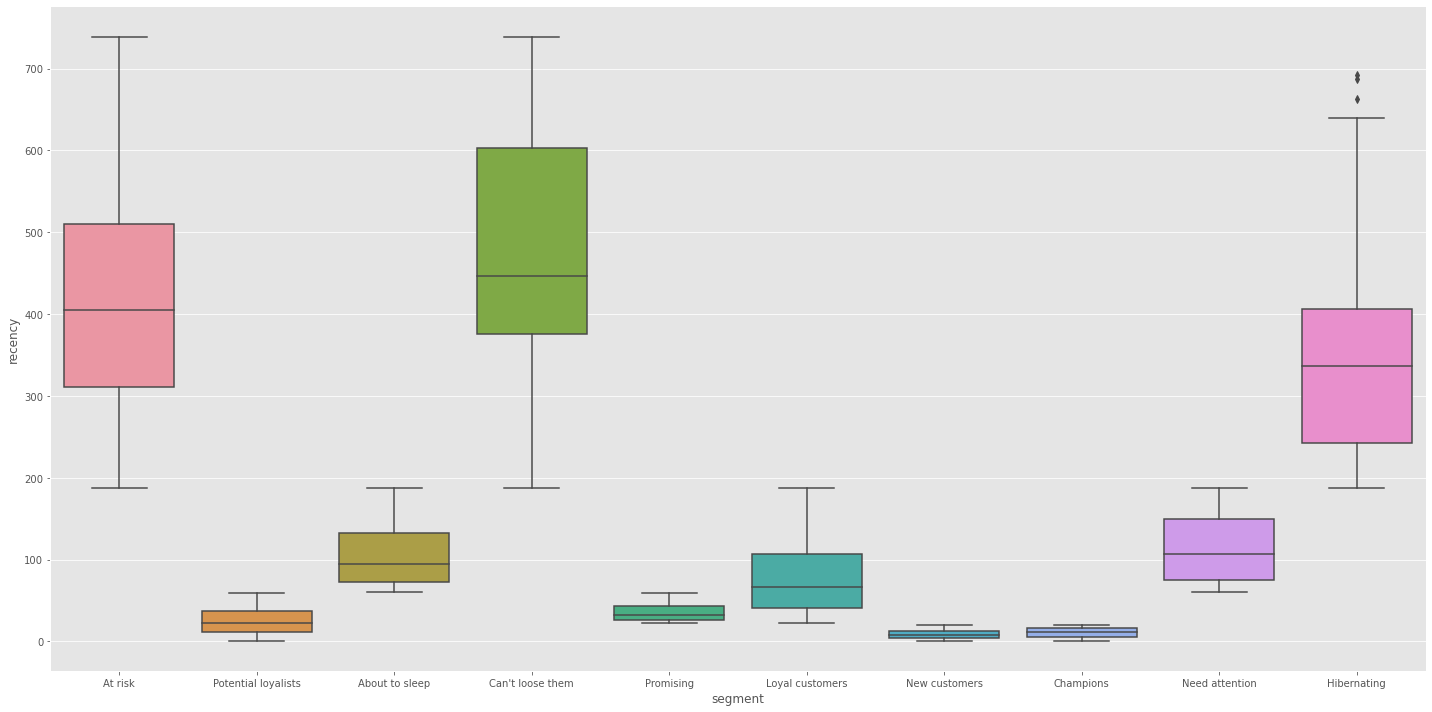

In [107]:
plt.figure(figsize=(20,10))
sns.boxplot(x=RFM['segment'], y=RFM['recency'])
save_fig("recency")
plt.show();

그림 저장: frequency


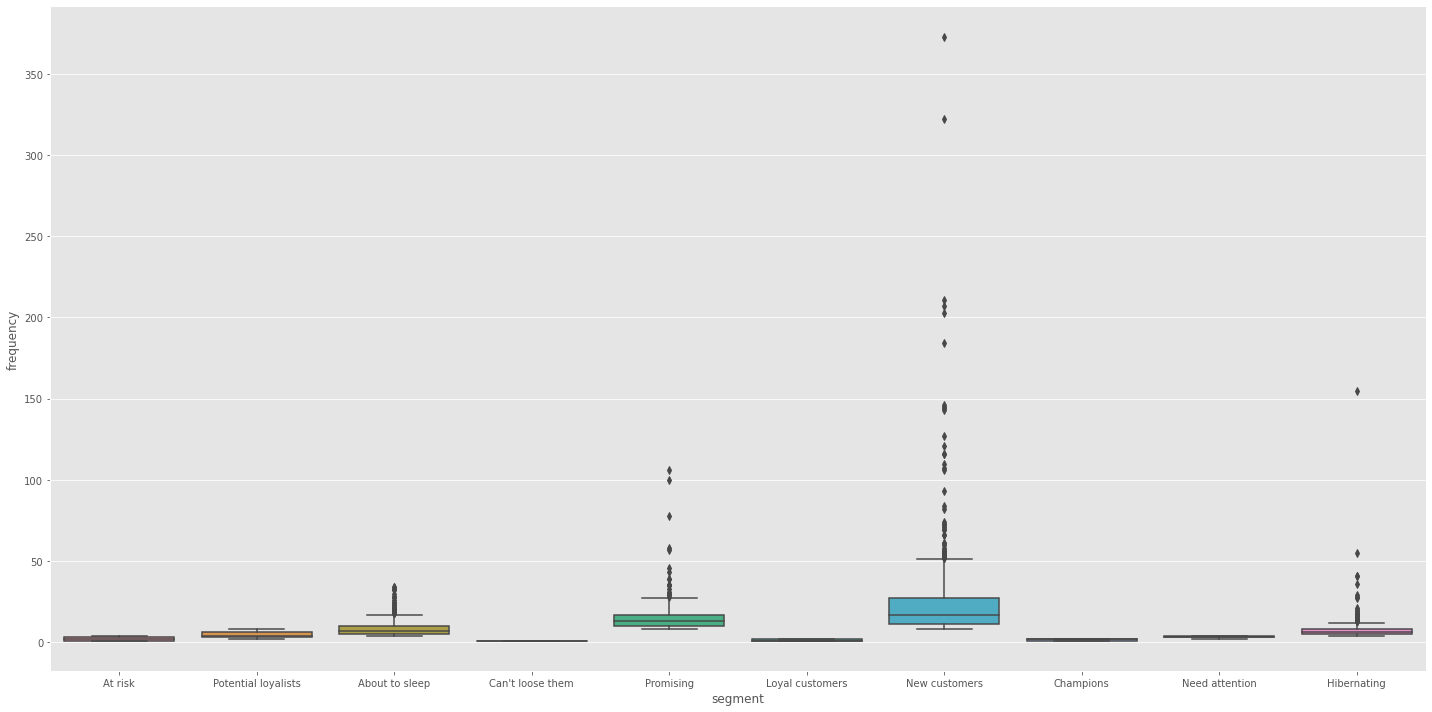

In [108]:
plt.figure(figsize=(20,10))
sns.boxplot(x=RFM['segment'], y=RFM['frequency'])
save_fig("frequency")
plt.show();

그림 저장: monetary


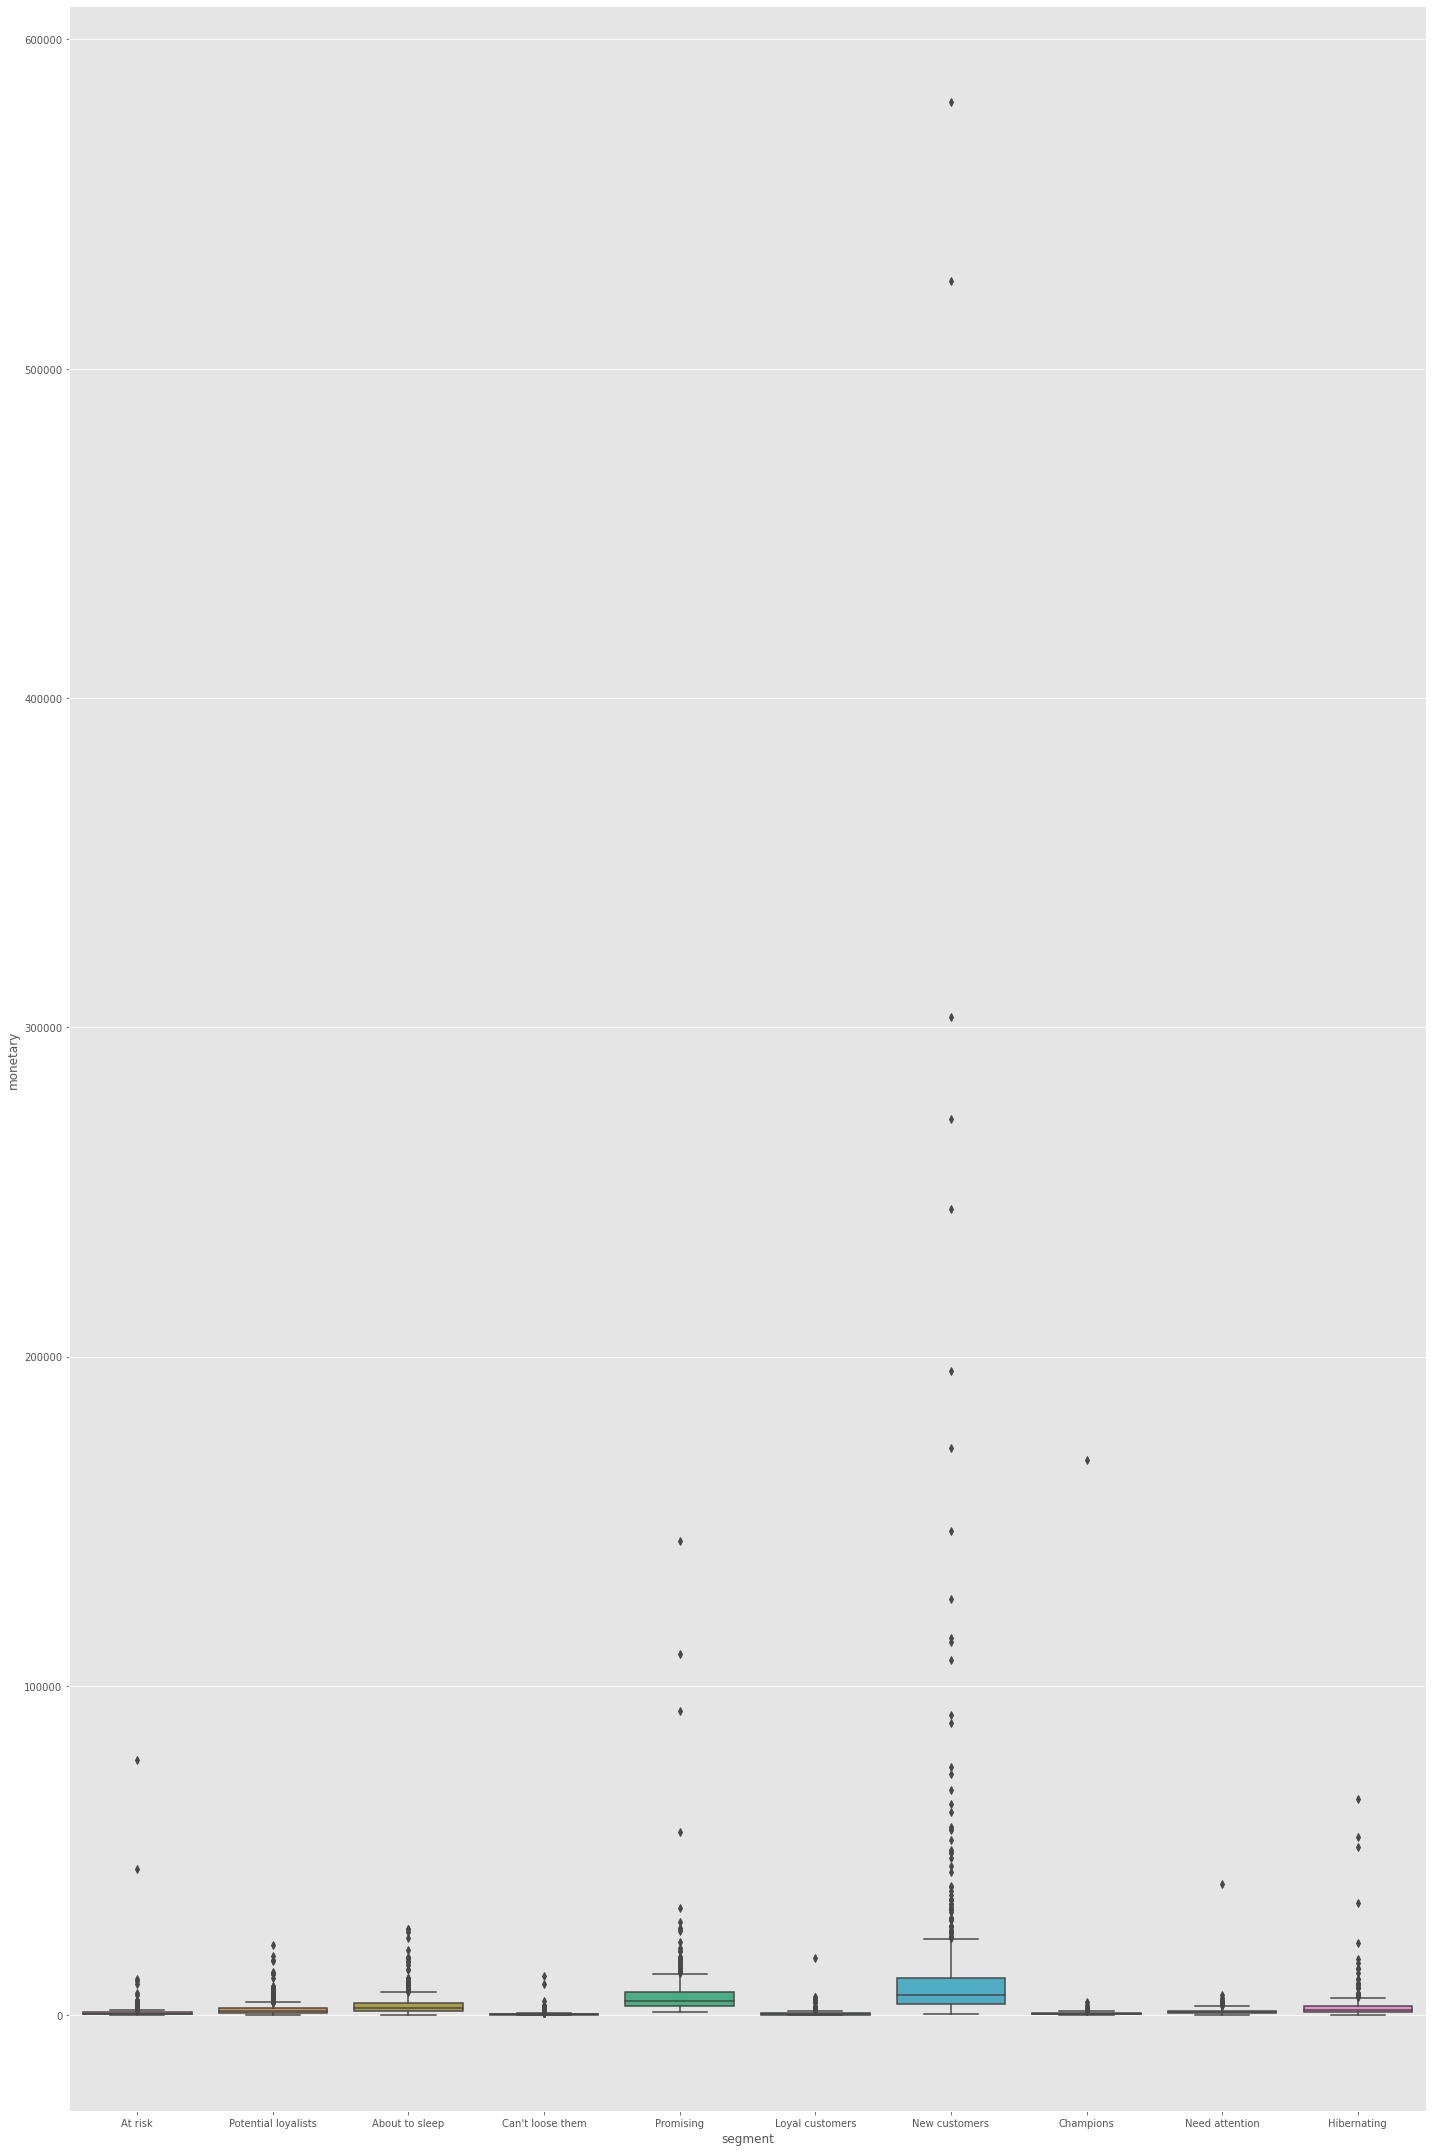

In [109]:
plt.figure(figsize=(20,30))
sns.boxplot(x=RFM['segment'], y=RFM['monetary'])
save_fig("monetary")
plt.show();

그림 저장: recency frequency segment scatter


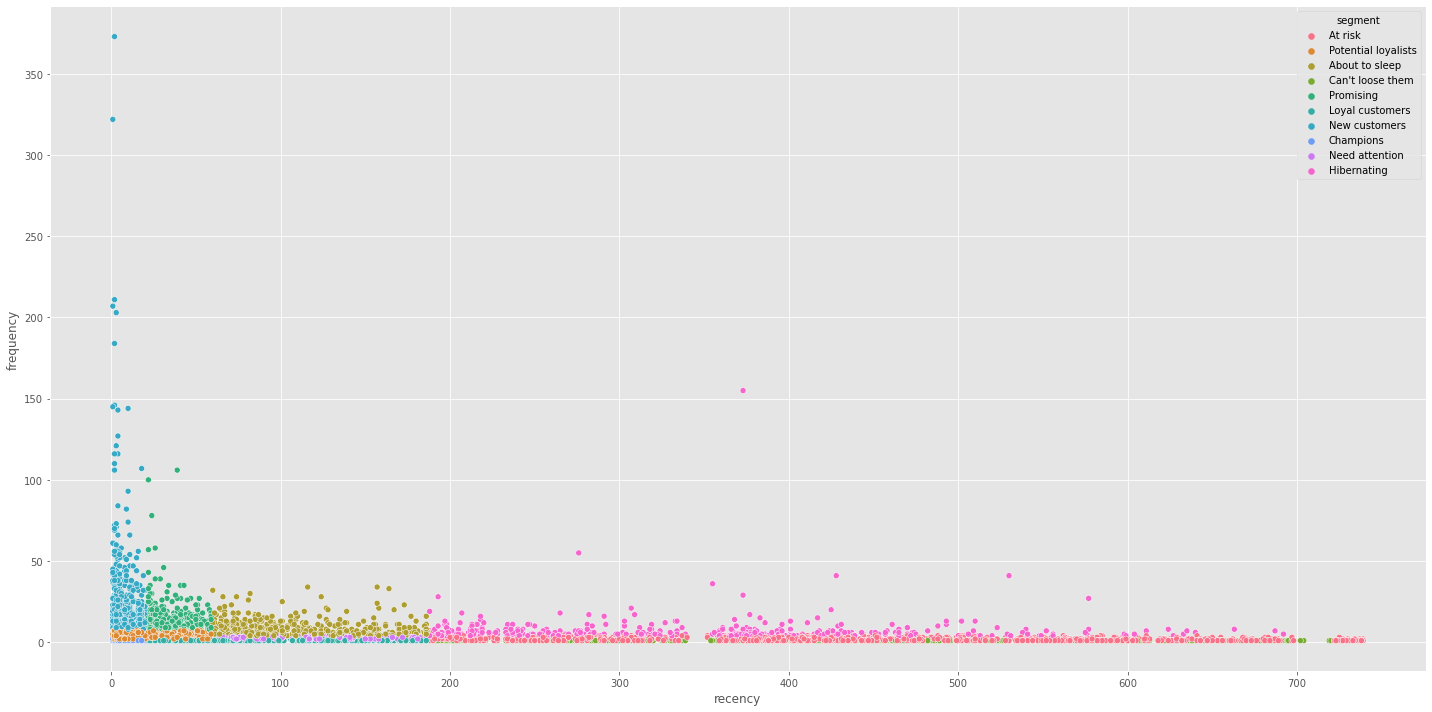

In [110]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=RFM['recency'], y=RFM['frequency'], hue=RFM['segment'])
save_fig("recency frequency segment scatter")
plt.show();

In [ ]:
# b = RFM_data.groupby(['segment','Country']).count()['Customer ID'].to_frame().reset_index()
# b_pivot = b.pivot("segment","Country","Customer ID")
# b_pivot = b_pivot.fillna("0")
# b_pivot = b_pivot.astype(int)

# category_names = list(b_pivot.columns)
# labels = list(b_pivot.index)
# data = b_pivot.values
# data_cum = data.cumsum(axis=1)
# category_colors = sns.color_palette("flare", as_cmap=True)(np.linspace(0.15, 0.85, data.shape[1]))
# fig, ax = plt.subplots()
# ax.invert_yaxis()
# ax.xaxis.set_visible(False)
# ax.set_xlim(0, np.sum(data, axis=1).max())

# for i, (colname, color) in enumerate(zip(category_names, category_colors)):
#     widths = data[:, i]
#     starts = data_cum[:, i] - widths
#     rects = ax.barh(labels, widths, left=starts, height=0.5,
#                     label=colname, color=color)

#     r, g, b, _ = color
#     text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
#     ax.bar_label(rects, label_type='center', color=text_color)

# ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
#           loc='lower left', fontsize='xx-large')

In [111]:
at_risk = RFM_data[RFM_data['segment'] == 'At risk']
potential_loyalists = RFM_data[RFM_data['segment'] == 'Potential loyalists']
about_to_sleep = RFM_data[RFM_data['segment'] == 'About to sleep']
cant_loose_them = RFM_data[RFM_data['segment'] == "Can't loose them"]
promising = RFM_data[RFM_data['segment'] == "Promising"]
loyal_customers = RFM_data[RFM_data['segment'] == "Loyal customers"]
new_customers = RFM_data[RFM_data['segment'] == "New customers"]
champions = RFM_data[RFM_data['segment'] == "Champions"]
need_attention = RFM_data[RFM_data['segment'] == "Need attention"]
hibernating = RFM_data[RFM_data['segment'] == "Hibernating"]

### Country

그림 저장: Country


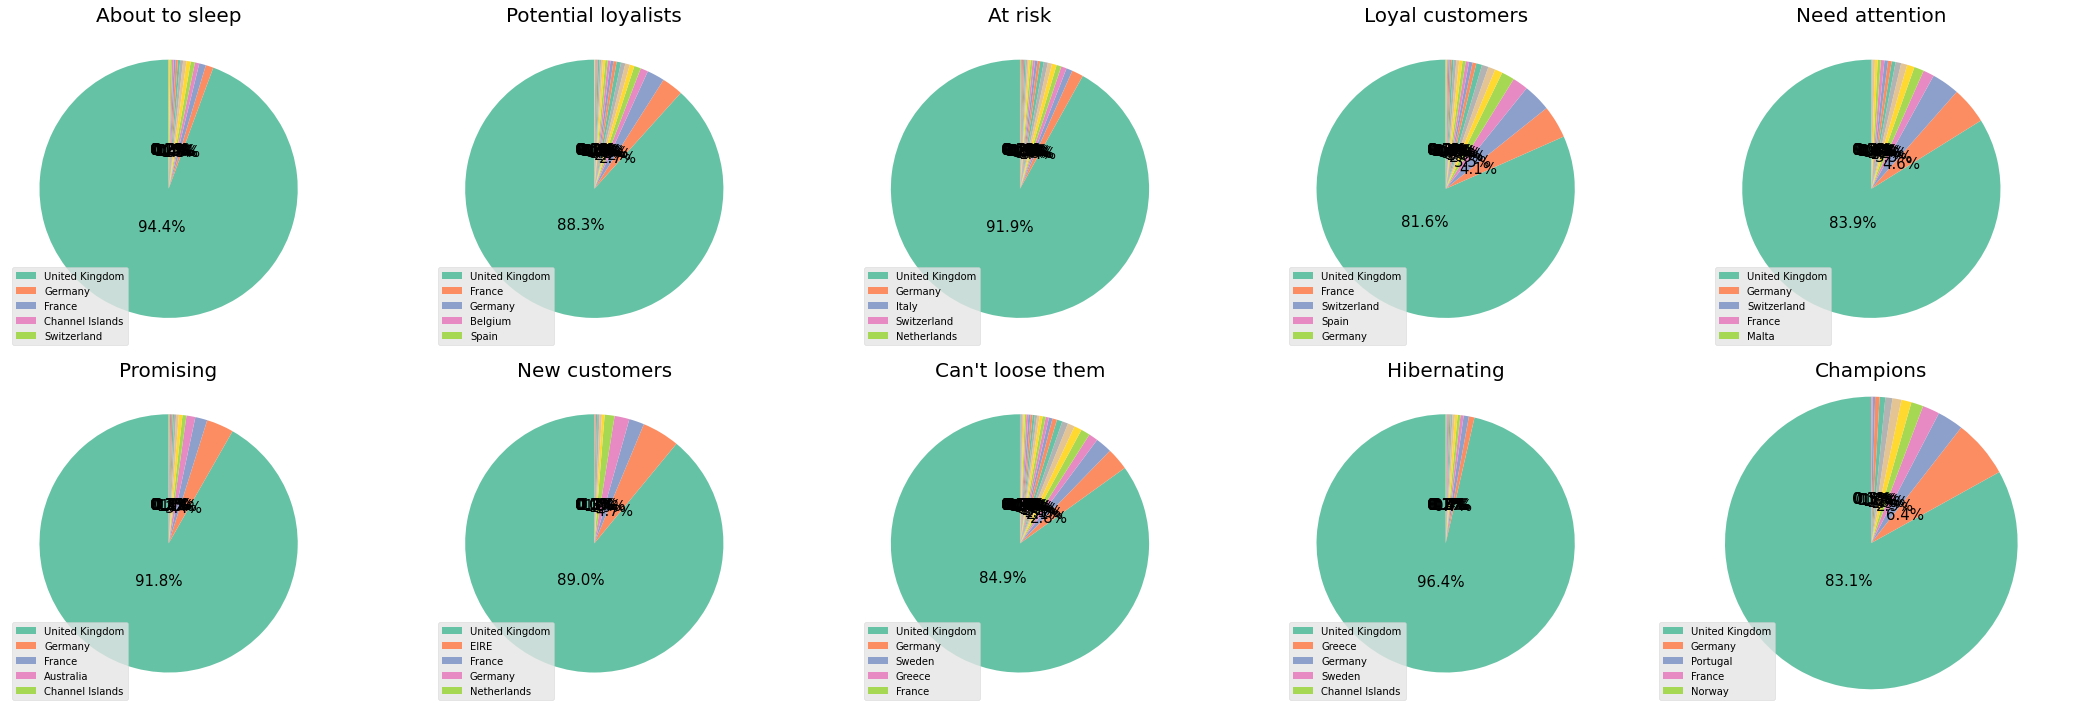

In [112]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for idx, var in enumerate(RFM_data['segment'].unique()):
    df = RFM_data[RFM_data['segment'] == var]
    i = idx % 2
    j = idx % 5
    
    ax[i][j].pie(df['Country'].value_counts(),
             autopct='%0.1f%%',
             textprops={'fontsize': 15},
             pctdistance=0.3,
             startangle=90,
             colors=sns.color_palette("Set2"))
    ax[i][j].set_title(f'{var}'.format(), fontsize=20)
    plt.axis('equal') 
    ax[i][j].legend(df['Country'].value_counts()[:5].index, loc='lower left', fontsize=10)

save_fig("Country")
plt.show();

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for idx, var in enumerate(RFM_data['segment'].unique()):
    df = RFM_data[RFM_data['segment'] == var]
    df = df[df['Country'] != 'United Kingdom']
    i = idx % 2
    j = idx % 5
    
    ax[i][j].pie(df['Country'].value_counts(),
             autopct='%0.1f%%',
             textprops={'fontsize': 10},
             pctdistance=0.3,
             startangle=90,
             colors=sns.color_palette("Set2"))
    ax[i][j].set_title(f'{var}'.format(), fontsize=20)
    plt.axis('equal') 
    ax[i][j].legend(df['Country'].value_counts()[:5].index, loc='lower left', fontsize=10)

save_fig("Country without UK")
plt.show();

### Products

In [ ]:
import nltk
import swifter
from nltk.corpus import stopwords
from collections import Counter

In [ ]:
def nn_words(df):
    df = df[df['segment'] == var]
    word_tokens = df['Description'].apply(lambda x : nltk.word_tokenize(x))
    tokens_pos = word_tokens.swifter.apply(lambda x :nltk.pos_tag(x))
    NN_words = []
    
    for i in range(len(tokens_pos)):
        for word, pos in tokens_pos.iloc[i]:
            if 'NN' in pos:
                NN_words.append(word)                
    return NN_words

In [ ]:
def common_words (NN_words, k):
    c = Counter(NN_words)
    common_words = c.most_common(k)
    common_words_df = pd.DataFrame(common_words, columns=['noun', 'counts'])
    return common_words_df

In [ ]:
RFM_data['Description'] = RFM_data['Description'].str.lower()
stopwords_list = stopwords.words('english')

fig, ax = plt.subplots(2, 5, figsize=(30, 10))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

for idx, var in enumerate(RFM_data['segment'].unique()):
    NN_words = nn_words(RFM_data)
    common_words_df = common_words(NN_words, 5)
    
    i = idx % 2
    j = idx % 5
    
    sns.barplot(common_words_df['noun'], common_words_df['counts'], ax = ax[i][j]).set_title(f'{var}'.format(), fontsize=20)
    ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=30, size=15)
    ax[i][j].set_xlabel("")
    ax[i][j].set_ylabel("")
   
save_fig("most common word by segments")
plt.show();

In [ ]:
christmas = RFM_data[RFM_data['Description'].str.contains("christmas")]
plt.figure(figsize=(30,10))
sns.countplot(christmas['month'], hue=christmas['year'])
plt.title('christmas', fontsize=20)
plt.xlabel("")
plt.ylabel("")
save_fig("word christmas products transactions")
plt.show();

In [ ]:
christmas_list = ["Champions", "Potential loyalists", "Loyal customers"]

fig, ax = plt.subplots(3, figsize=(30, 20))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

for idx, var in enumerate(christmas_list):
    df = RFM_data[RFM_data['segment'] == var]
    df = df[['Invoice', 'year', 'month']].groupby(['Invoice','year', 'month']).count().reset_index()

    i = idx % 3
    
    sns.countplot(df['month'], hue=df['year'], ax = ax[i]).set_title(f'{var}'.format(), fontsize=20)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0, size=15)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
save_fig("word christmas products transactions(segments)")
plt.show();

In [ ]:
# 1인당 평균 결제액

In [ ]:
RFM_data

In [ ]:
RFM_data[RFM_data['Customer ID'] == 12346.0]['total_price'].sum()

In [ ]:
for i in RFM_data['segment'].unique():
    df = RFM_data[RFM_data['segment'] == i]
    arppu = df['total_price'].sum() / df['Customer ID'].nunique()
    print({i:arppu})
    print({i:df['Customer ID'].nunique()})
    print({i: arppu * df['Customer ID'].nunique() })
    

In [ ]:
RFM_data.['Customer ID'].nunique()

In [ ]:
RFM_data['total_price'].sum() / RFM_data['Customer ID'].nunique()

In [ ]:
# Outside Ring
fig, ax = plt.subplots()
ax.axis('equal')
pie_outside, _ = ax.pie(group_sizes, 
                        radius=1.3, 
                        labels=group_names, 
                        labeldistance=0.8,
                        colors=[a(0.6), b(0.6), c(0.6)])
plt.setp(pie_outside, 
         width=width_num, 
         edgecolor='white')

# Inside Ring
pie_inside, plt_labels, junk = \
    ax.pie(subgroup_sizes, 
           radius=(1.3 - width_num), 
           labels=subgroup_names, 
           labeldistance=0.75, 
           autopct='%1.1f%%', 
           colors=[a(0.5), a(0.4), a(0.3), a(0.2), 
                   b(0.5), b(0.4), b(0.3), 
                   c(0.5), c(0.4)])
plt.setp(pie_inside, 
         width=width_num, 
         edgecolor='white')
plt.title('Donut Plot with Subgroups', fontsize=20)
plt.show()


In [ ]:
champions['Country'].count()

In [ ]:
pd.DataFrame(champions['Country'].value_counts() / champions['Country'].count() * 100)

In [ ]:
champions['Country'].value_counts().index

In [ ]:
# champions
sns.countplot(champions['Country'])

In [ ]:
# 아웃라이어
plt.figure(figsize=(20,30))
sns.boxplot(x=RFM['segment'], y=RFM['monetary'])

In [ ]:
# 아웃라이어
plt.figure(figsize=(20,30))
sns.boxplot(x=RFM['segment'], y=RFM['frequency'])

In [ ]:
RFM

In [ ]:
RFM_tmp = RFM[RFM['monetary'] < 100000]

In [ ]:
plt.figure(figsize=(20,30))
sns.boxplot(x=RFM_tmp['segment'], y=RFM_tmp['monetary'])

In [ ]:
plt.figure(figsize=(20,30))
sns.boxplot(RFM[RFM['segment'] == 'At risk']['monetary'])

In [ ]:
RFM.describe()

In [ ]:
RFM[RFM['segment'] == 'At risk']['monetary']

In [ ]:
sns.boxplot(x=RFM['segment'], y=RFM['monetary'])

In [ ]:
RFM[RFM['segment'] == 'At risk'].describe()

In [ ]:
at_risk['monetary'].value_counts()

In [ ]:
tmp = RFM_data.copy()

In [ ]:
quartile1 = tmp['monetary'].quantile(0.01)
quartile3 = tmp['monetary'].quantile(0.99)

In [ ]:
quartile1, quartile3

In [ ]:
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

In [ ]:
up_limit, low_limit

In [ ]:
tmp.loc[(tmp['monetary'] < low_limit), ['monetary']] = low_limit
tmp.loc[(tmp['monetary'] > up_limit), ['monetary']] = up_limit

In [ ]:
tmp

참고
- https://towardsdatascience.com/know-your-customers-with-rfm-9f88f09433bc
- https://towardsdatascience.com/automated-customer-segmentation-2f9cec9df4df
- https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
- https://towardsdatascience.com/tagged/rfm-analysis
- https://hungryap.tistory.com/69
- https://www.kaggle.com/sercanyesiloz/crm-analytics 
- https://zephyrus1111.tistory.com/13
- https://www.kaggle.com/slehkyi/e-commerce-predicting-sales